# MAG Dereplication and Beta Diversity Analysis
### Presence/Absence MAG-Based Community Comparison

This notebook documents the full workflow used to:

- Dereplicate filtered MAGs using moshpit (sourmash k-mer comparisons)
- Build sample-MAG presence/absence feature tables
- Compute beta diversity
- Compare microbial communities between sample categories
- Evaluate metadata effects with PERMANOVA

#### **Goal**

The following is the goal of this subsection, as presented in the project description:

**Compare microbial communities between samples -> Determine which samples are more alike in terms of reconstructed genomes.**

<div style="border:2px solid red; padding:10px; color:red; font-weight:bold;">
Note: All of the code that is commented out is due to the fact that running the would likely take time. The code that was run as scripts is also shown, and the full scripts are also available in the files you will donwload for the notebook. Additionally, the commentary in the initial portion of the notebook is explaining the necessary steps needed to be taken to conduct the dereplication, hence the mentioning of directories and other portions. More notes and explanations will be added in places where the actions are unclear. 
</div>

#### **Notebook Content:** ####

- [Prepare Environment](#prepare-environment)
- [Collecting MAGs from Cache Keys](#step-1-collecting-mags-from-cache-keys)
- [Preparing Dereplication Inputs](#step-2-preparing-dereplication-inputs)
- [Building Input Folder](#step-3-building-input-folders)
- [Importing MAGs into Moshpit Cache](#step-4a-importing-mags-into-moshpit-cache)
- [Computing MinHash Signatures](#step-4b-computing-minhash-signatures)
- [Computing MAG-MAG Distance Matrix](#step-4c-computing-mag-mag-distance-matrix)
- [Dereplicate MAGs](#step-5-dereplicate-mags)
- [Calculate Beta Diversity](#step-6-calculate-beta-diversity)
- [Visualizations](#step-7-visualizations)

### **The workflow** ###

### Prepare Environment

#### Import Packages

In [1]:
#set up environment
import qiime2
import pandas as pd
import numpy as np
import seaborn as sns
from qiime2 import Visualization

%matplotlib inline
import matplotlib.pyplot as plt
import skbio

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# create directories for the notebook. DO NOT change
data_dir = 'data/03_Beta_Diversity_Analysis'
!data_dir = 'data/03_Beta_Diversity_Analysis'

!mkdir -p data
!mkdir -p $data_dir

# fetches useful files for the current notebook. All files will be saved in $data_dir
!wget 'https://polybox.ethz.ch/index.php/s/S2tMLEpxCJqn9Di/download' -O data/Download.zip
!unzip -o data/Download.zip -d data
!rm data/Download.zip

/usr/bin/sh: line 1: data_dir: command not found
--2025-12-06 14:16:22--  https://polybox.ethz.ch/index.php/s/S2tMLEpxCJqn9Di/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘data/Download.zip’

data/Download.zip       [  <=>               ] 121.47M   399MB/s    in 0.3s    

2025-12-06 14:16:22 (399 MB/s) - ‘data/Download.zip’ saved [127367649]

Archive:  data/Download.zip
 extracting: data/03_Beta_Diversity_Analysis/build_derep_domain.sh  
 extracting: data/03_Beta_Diversity_Analysis/build_derep_input_dirs.sh  
 extracting: data/03_Beta_Diversity_Analysis/mag_domains_derep.qza  
 extracting: data/03_Beta_Diversity_Analysis/mags_derep_95_all_domains.qza  
 extracting: data/03_Beta_Diversity_Analysis/mags_feature_table_95_all_domains.qza  
 extracting: data/03_Beta_Diversity_Analysis/metad

### Step 1. Collecting MAGs from Cache Keys

In the previous notebook, we ran a BUSCO analysis for our data. Following the BUSCO analysis, the MAGs were subjected to a filtering step for bacterial MAGs, archaeal MAGs, and eukaryotic MAGs, based on the following thresholds:

- **completeness >= 50%, contamination <= 10%.** 

These thresholds are found in [citation -> will be provided] and are the thresholds for medium quality samples. We decided to use these 

The following commands were used:

In [2]:
'''%%bash
mosh annotate filter-mags \
    --i-mags /cluster/scratch/fabazi/cache:mags \
    --m-metadata-file /cluster/scratch/fabazi/cache:bacteria_busco_results \
    --p-where 'completeness>50 AND contamination<10' \
    --p-no-exclude-ids \
    --p-on mag \
    --o-filtered-mags /cluster/scratch/fabazi/cache:mags_filtered_bacteria \
    --verbose'''

"%%bash\nmosh annotate filter-mags     --i-mags /cluster/scratch/fabazi/cache:mags     --m-metadata-file /cluster/scratch/fabazi/cache:bacteria_busco_results     --p-where 'completeness>50 AND contamination<10'     --p-no-exclude-ids     --p-on mag     --o-filtered-mags /cluster/scratch/fabazi/cache:mags_filtered_bacteria     --verbose"

In [3]:
'''%%bash
mosh annotate filter-mags \
    --i-mags /cluster/scratch/fabazi/cache:mags \
    --m-metadata-file /cluster/scratch/fabazi/cache:archaea_busco_results \
    --p-where 'completeness>50 AND contamination<10' \
    --p-no-exclude-ids \
    --p-on mag \
    --o-filtered-mags /cluster/scratch/fabazi/cache:mags_filtered_archaea \
    --verbose'''

"%%bash\nmosh annotate filter-mags     --i-mags /cluster/scratch/fabazi/cache:mags     --m-metadata-file /cluster/scratch/fabazi/cache:archaea_busco_results     --p-where 'completeness>50 AND contamination<10'     --p-no-exclude-ids     --p-on mag     --o-filtered-mags /cluster/scratch/fabazi/cache:mags_filtered_archaea     --verbose"

In [4]:
'''%%bash
mosh annotate filter-mags \
    --i-mags /cluster/scratch/fabazi/cache:mags \
    --m-metadata-file /cluster/scratch/fabazi/cache:eukaryota_busco_results \
    --p-where 'completeness>50 AND contamination<10' \
    --p-no-exclude-ids \
    --p-on mag \
    --o-filtered-mags /cluster/scratch/fabazi/cache:mags_filtered_eukaryota \
    --verbose'''

"%%bash\nmosh annotate filter-mags     --i-mags /cluster/scratch/fabazi/cache:mags     --m-metadata-file /cluster/scratch/fabazi/cache:eukaryota_busco_results     --p-where 'completeness>50 AND contamination<10'     --p-no-exclude-ids     --p-on mag     --o-filtered-mags /cluster/scratch/fabazi/cache:mags_filtered_eukaryota     --verbose"

Since this was done inside the cache, each filtered groups of MAGs corresponded to a specific cache key. The following three MAG cache keys were identified:

- Bacteria: f095dffd-7095-45e4-8449-d9739ba7c183
- Archaea: 465127cf-8602-4724-a8d0-3db8861cc4b4
- Eukaryota: fee65776-ffb2-4f96-9554-aa8d72d1207d


Each of these keys points to a folder structure as following: /cluster/scratch/fabazi/cache/data/<UUID>/data/SAMPLE_ID/*.fasta
    
Non-MAG folders and files existed inside of the cache keys (e.g., annotations, temporary data, etc.). This required filtering only the MAGS folder, to avoid linking unwanted files.

### Step 2. Preparing Dereplication Inputs

Two directories were created:

- DEREP_input_mag_paths_list
 -> contains a cleaned list of sample MAG directories
 
- DEREP_combined_MAGs_for_moshpit
 -> contains symlinked MAGs, grouped per sample, ready for MultiFASTADirectory Format

This step ensures a clean, unified dataset for dereplication across all domains.

### Step 3. Building Input Folders

Next, a script called build_derep_input_dirs.sh was run. This script:
- scans each MAG key
- collects sample directories
- filters out unwanted folders
- symlinks FASTA files into per-sample folders
- handles duplicate MAG UUIDs safely
- builds a dereplication suitable directory
- produces the directory format required by '--input-format MultiFASTADirectoryFormat'

The following script was run:

In [5]:
!cat $data_dir/'build_derep_input_dirs.sh'

#!/bin/bash
set -e

echo "Building combined MAG directory for DEREP"


# 1. DEFINING CACHE AND KEYS

CACHE_DATA="/cluster/scratch/fabazi/cache/data"

# Domain-specific MAG keys (UUIDs)
KEY_BACTERIA="f095dffd-7095-45e4-8449-d9739ba7c183"
KEY_ARCHAEA="465127cf-8602-4724-a8d0-3db8861cc4b4"
KEY_EUKARYOTA="fee65776-ffb2-4f96-9554-aa8d72d1207d"

# Output folder names
LIST_DIR="/cluster/scratch/fabazi/DEREP_input_mag_paths_list"
COMBINED_DIR="/cluster/scratch/fabazi/DEREP_combined_MAGs_for_moshpit"

echo "Cache: $CACHE_DATA"
echo "Output list dir: $LIST_DIR"
echo "Combined MAG dir: $COMBINED_DIR"
echo ""


# 2. PREPARING OUTPUT DIRECTORIES

echo "Preparing directories"

mkdir -p "$LIST_DIR"
rm -rf "$COMBINED_DIR"
mkdir -p "$COMBINED_DIR"

LIST_FILE="$LIST_DIR/all_mag_dirs_clean.txt"
> "$LIST_FILE"


# 3. COLLECTING MAG DIRECTORIES FROM KEYS

echo "Collecting sample directories from MAG keys"

for KEY in "$KEY_BACTERIA" "$KEY_ARCHAEA" "$KEY_EUKARYOTA"; do
    KEY_PATH="$CACHE_DATA/$KEY"

    i

### Step 4A. Importing MAGs into Moshpit Cache

All MAGs are organized per sample in: './DEREP_combined_MAGs_for_moshpit/'. 

They are imported as a single dataset into moshpit:

In [6]:
'''%%bash
mosh tools cache-import \
  --cache /cluster/scratch/fabazi/cache \
  --key mags_filtered_all_domains_for_derep \
  --type "SampleData[MAGs]" \
  --input-path /cluster/scratch/fabazi/DEREP_combined_MAGs_for_moshpit \
  --input-format MultiFASTADirectoryFormat'''

'%%bash\nmosh tools cache-import   --cache /cluster/scratch/fabazi/cache   --key mags_filtered_all_domains_for_derep   --type "SampleData[MAGs]"   --input-path /cluster/scratch/fabazi/DEREP_combined_MAGs_for_moshpit   --input-format MultiFASTADirectoryFormat'

### Step 4B. Computing MinHash Signatures

This computes k-mer sketches for evety MAG:

In [7]:
'''%%bash
mosh sourmash compute \
  --i-sequence-file ./cache:mags_filtered_all_domains_for_derep \
  --p-ksizes 35 \
  --p-scaled 10 \
  --o-min-hash-signature ./cache:mags_minhash_all_domains_derep \
  --verbose'''

'%%bash\nmosh sourmash compute   --i-sequence-file ./cache:mags_filtered_all_domains_for_derep   --p-ksizes 35   --p-scaled 10   --o-min-hash-signature ./cache:mags_minhash_all_domains_derep   --verbose'

### Step 4C. Computing MAG-MAG Distance Matrix

MAGs are compared using sourmash. This generates a full pwairwise distance matrix of all MAGs:

In [8]:
'''%%bash
mosh sourmash compare \
  --i-min-hash-signature ./cache:mags_minhash_all_domains_derep \
  --p-ksize 35 \
  --o-compare-output ./cache:mags_dist_matrix_all_domains_derep \
  --verbose'''

'%%bash\nmosh sourmash compare   --i-min-hash-signature ./cache:mags_minhash_all_domains_derep   --p-ksize 35   --o-compare-output ./cache:mags_dist_matrix_all_domains_derep   --verbose'

### Step 5. Dereplicate MAGs

This clusters highly similar MAGs based on 95% ANI-like threshold, and keeps a representative genome. The 95% was chosen since this is the standardly accepted species-level cutoff (relevant citation will be added), ensuring that each microbial species is counted only once, and preventing preventing duplicate MAGs from biasing presence/absence based community comparisons.

Output from this step: 
- 'mags_derep_95_all_domains' -> dereplicated MAGs
- 'mags_feature_table_95_all_domains' -> sample MAG presence/absence

In [9]:
'''%%bash
mosh annotate dereplicate-mags \
  --i-mags ./cache:mags_filtered_all_domains_for_derep \
  --i-distance-matrix ./cache:mags_dist_matrix_all_domains_derep \
  --p-threshold 0.95 \
  --o-dereplicated-mags ./cache:mags_derep_95_all_domains \
  --o-table ./cache:mags_feature_table_95_all_domains \
  --verbose'''

'%%bash\nmosh annotate dereplicate-mags   --i-mags ./cache:mags_filtered_all_domains_for_derep   --i-distance-matrix ./cache:mags_dist_matrix_all_domains_derep   --p-threshold 0.95   --o-dereplicated-mags ./cache:mags_derep_95_all_domains   --o-table ./cache:mags_feature_table_95_all_domains   --verbose'

The dereplicated outputs were then exported from moshpit cache. The dereplicated MAG directory ('.qza'), and the dereplicated feature table ('.qza') were exported:

In [10]:
'''%%bash
mosh tools cache-fetch \
  --cache /cluster/scratch/fabazi/cache \
  --key mags_derep_95_all_domains \
  --output-path mags_derep_95_all_domains.qza

mosh tools cache-fetch \
  --cache /cluster/scratch/fabazi/cache \
  --key mags_feature_table_95_all_domains \
  --output-path mags_feature_table_95_all_domains.qza'''

'%%bash\nmosh tools cache-fetch   --cache /cluster/scratch/fabazi/cache   --key mags_derep_95_all_domains   --output-path mags_derep_95_all_domains.qza\n\nmosh tools cache-fetch   --cache /cluster/scratch/fabazi/cache   --key mags_feature_table_95_all_domains   --output-path mags_feature_table_95_all_domains.qza'

**Building dereplicated MAG ID List**

Exporting the dereplicated feature table to extract MAG IDs.

In [11]:
'''%%bash
qiime tools export \
  --input-path mags_feature_table_95_all_domains.qza \
  --output-path derep_export

biom convert \
  --i derep_export/feature-table.biom \
  --o derep_feature_table.tsv \
  --to-tsv'''

'%%bash\nqiime tools export   --input-path mags_feature_table_95_all_domains.qza   --output-path derep_export\n\nbiom convert   --i derep_export/feature-table.biom   --o derep_feature_table.tsv   --to-tsv'

**Merge dereplicated MAGs with domain classification**

Because dereplication mixes genomes from multiple domains, the mapping needs to be rebuilt: MAG -> Domain.

This uses a separate file called 'mag_domains_nondedup.tsv'. The code was run as a script 'build_derep_domain.sh'.

In [12]:
!cat $data_dir/'build_derep_domain.sh'

#!/bin/bash
set -e

echo " DEREPLICATED MAG DOMAIN LINKING"

# Required inputs:
#   mags_feature_table_95_all_domains.qza
#   mag_domains_nondedup.tsv
#
# Outputs:
#   derep_mag_ids.txt
#   mag_domains_derep_qiime.tsv
#   mag_domains_derep.qza

# 1. Check inputs
echo "Checking required files..."

if [[ ! -f "mags_feature_table_95_all_domains.qza" ]]; then
    echo "ERROR: mags_feature_table_95_all_domains.qza not found!"
    exit 1
fi

if [[ ! -f "mag_domains_nondedup.tsv" ]]; then
    echo "ERROR: mag_domains_nondedup.tsv not found!"
    exit 1
fi

echo "All required files present."


# 2. Export BIOM from feature table
echo "Exporting BIOM file"
mkdir -p derep_export

qiime tools export \
  --input-path mags_feature_table_95_all_domains.qza \
  --output-path derep_export

echo "BIOM exported."


# 3. Convert BIOM → TSV
echo "Converting BIOM to TSV"

biom convert \
  -i derep_export/feature-table.biom \
  -o derep_feature_table.tsv \
  --to-tsv

echo "BIOM converted."


# 4. Extract d

At this stage, the metadata file also needed to be changed:

In [13]:
'''# fixing metadata file

cd ./dereplication_results/

sed -i '1s/#SampleID/sample-id/' metadata_qiime_ready.tsv
sed -i 's/\r$//' metadata_qiime_ready.tsv #to remove any artifacts

#validating the metadata file

qiime metadata tabulate \
  --m-input-file metadata_qiime_ready.tsv \
  --o-visualization metadata_validation.qzv'''

"# fixing metadata file\n\ncd ./dereplication_results/\n\nsed -i '1s/#SampleID/sample-id/' metadata_qiime_ready.tsv\nsed -i 's/\r$//' metadata_qiime_ready.tsv #to remove any artifacts\n\n#validating the metadata file\n\nqiime metadata tabulate   --m-input-file metadata_qiime_ready.tsv   --o-visualization metadata_validation.qzv"

**<u>Note: From this point in the notebook the code should run properly.<u>**

### Step 6. Calculate Beta Diversity

A Bray-Curtis distance matrix would be the usual matrix used to estimate beta diversity. However, a Bray-Curtis distance matrix requires an abundance table, which we were unable to produce. The main reason is due to the large read files, and this process would be too computationally intensive. Additionally, read mapping for long reads is not well established in moshpit. For short read mapping we would need to generate intermediate files which uses the same or more disk space than the original fastq files. Lastly, abundance comparisons between sequencing platforms are tricky since the sequencing efforts and coverages are very different.


Therefore, we could only work with the diversity matrix that uses presence/absence tables: the Jaccard distance matrix.

In [14]:
# Jaccard

! qiime diversity beta \
  --i-table $data_dir/mags_feature_table_95_all_domains.qza \
  --p-metric jaccard \
  --o-distance-matrix $data_dir/derep_jaccard_distance_taxonomy.qza

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved DistanceMatrix to: data/03_Beta_Diversity_Analysis/derep_jaccard_distance_taxonomy.qza


In [15]:
# PCoA and emperor plot

! qiime diversity pcoa \
  --i-distance-matrix $data_dir/derep_jaccard_distance_taxonomy.qza \
  --o-pcoa $data_dir/derep_jaccard_pcoa_taxonomy.qza

! qiime emperor plot \
  --i-pcoa $data_dir/derep_jaccard_pcoa_taxonomy.qza \
  --m-metadata-file $data_dir/metadata_qiime_ready.tsv \
  --o-visualization $data_dir/derep_jaccard_emperor_taxonomy.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved PCoAResults to: data/03_Beta_Diversity_Analysis/derep_jaccard_pcoa_taxonomy.qza
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/03_Beta_Diversity_Analysis/derep_jaccard_emperor_taxonomy.qzv


In [16]:
# PERMANOVA for different metadata categories

! qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/derep_jaccard_distance_taxonomy.qza \
  --m-metadata-file $data_dir/metadata_qiime_ready.tsv \
  --m-metadata-column samp_country \
  --p-method permanova \
  --o-visualization $data_dir/derep_permanova_country_taxonomy.qzv

! qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/derep_jaccard_distance_taxonomy.qza \
  --m-metadata-file $data_dir/metadata_qiime_ready.tsv \
  --m-metadata-column category \
  --p-method permanova \
  --o-visualization $data_dir/derep_permanova_category_taxonomy.qzv

! qiime diversity beta-group-significance \
  --i-distance-matrix $data_dir/derep_jaccard_distance_taxonomy.qza \
  --m-metadata-file $data_dir/metadata_qiime_ready.tsv \
  --m-metadata-column seq_tech \
  --p-method permanova \
  --o-visualization $data_dir/derep_permanova_seqtech_taxonomy.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/03_Beta_Diversity_Analysis/derep_permanova_country_taxonomy.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: data/03_Beta_Diversity_Analysis/derep_permanova_category_taxonomy.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/p

### Step 7. Visualizations

<div style="border:2px solid red; padding:10px; color:red; font-weight:bold;">
Note: This part of the notebook is messy. I did not manage to write the actual data interpretation here, I mostly focused on it in the report. But the finished version will have interpretation as well.  
</div>

Loading and inspecting the files:

In [17]:
# Load dereplicated MAG feature table (presence/absence)
table_art = qiime2.Artifact.load(f"{data_dir}/mags_feature_table_95_all_domains.qza")
table_df = table_art.view(pd.DataFrame)

# Load dereplicated domain assignment
tax_art = qiime2.Artifact.load(f"{data_dir}/mag_domains_derep.qza")
tax_df = tax_art.view(pd.DataFrame)

/opt/conda/envs/checkm/lib/python3.10/site-packages/q2_checkm/checkm.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [18]:
# Load metadata
metadata = pd.read_csv(f"{data_dir}/metadata_qiime_ready.tsv", sep='\t')
metadata = metadata.set_index("sample-id")

# Load distance matrix (Jaccard)
dist_art = qiime2.Artifact.load(f"{data_dir}/derep_jaccard_distance_taxonomy.qza")
skbio_dm = dist_art.view(skbio.DistanceMatrix)

# Convert to pandas DataFrame manually
jaccard_df = pd.DataFrame(skbio_dm.data,
                          index=skbio_dm.ids,
                          columns=skbio_dm.ids)

jaccard_df.head()

,IL_A001,IL_A002,IL_B037_La_Ac_La,IL_B038_Az_Gp_La,IL_B039_Aa_Gp_La,IL_B044_Hb_Ac_Ab,IL_B051_Aj_Po_Laf,IL_B056_Sc_Na_Af,IL_HM010-01,IL_HM010-03,...,PB_MS001-3,PB_MS003-2,PB_MS005-1,PB_MS009-1,PB_MS013-1,PB_P001,PB_P003,PB_P009,PB_a36ba,PB_e7c76
IL_A001,0.000,0.875,1.000000,1.0,1.000000,1.0,1.0,1.0,0.916667,0.8125,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
IL_A002,0.875,0.000,1.000000,1.0,1.000000,1.0,1.0,1.0,0.800000,1.0000,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
IL_B037_La_Ac_La,1.000,1.000,0.000000,1.0,0.857143,1.0,1.0,1.0,1.000000,1.0000,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
IL_B038_Az_Gp_La,1.000,1.000,1.000000,0.0,1.000000,1.0,1.0,1.0,1.000000,1.0000,...,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
IL_B039_Aa_Gp_La,1.000,1.000,0.857143,1.0,0.000000,1.0,1.0,1.0,1.000000,1.0000,...,0.857143,0.909091,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [19]:
# Load PCoA artifact
pcoa_art = qiime2.Artifact.load(f"{data_dir}/derep_jaccard_pcoa_taxonomy.qza")

# View as scikit-bio ordination results
pcoa_skbio = pcoa_art.view(skbio.OrdinationResults)

# Extract coordinates (samples × PCs)
pcoa_jac = pcoa_skbio.samples

pcoa_jac.head()

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
IL_A001,-0.414018,-0.061477,-0.038846,0.051112,0.100698,-0.118672,0.012646,-0.022474,0.071547,-0.006855,...,-0.094434,-0.046846,0.220399,0.153965,1.472324e-15,-0.007830,-0.003818,-0.093590,0.001552,-0.0
IL_A002,-0.306237,0.024009,-0.395891,0.050504,0.004464,-0.048101,0.101748,0.100357,-0.030327,-0.137762,...,0.113616,-0.149821,0.011012,-0.111008,1.000719e-14,-0.060405,-0.151771,-0.107727,-0.042043,-0.0
IL_B037_La_Ac_La,0.128086,-0.107163,-0.063937,-0.003579,0.083146,-0.019446,-0.020054,0.077498,0.108513,0.129007,...,0.060533,0.095807,0.008829,0.004439,-2.187946e-15,0.012554,-0.011518,-0.000661,-0.000939,-0.0
IL_B038_Az_Gp_La,0.041407,-0.005388,-0.002479,-0.039333,-0.044732,0.066115,-0.032100,0.017436,0.012394,-0.021688,...,-0.013912,0.001589,-0.003560,-0.001707,7.471190e-16,-0.003786,-0.003231,0.000117,-0.000421,-0.0
IL_B039_Aa_Gp_La,0.254676,-0.226753,-0.131867,0.066370,0.220739,-0.107611,0.002567,0.061300,0.085074,0.118303,...,-0.042951,-0.086515,0.023383,-0.008982,1.678841e-14,-0.100221,0.026410,0.002140,0.002406,-0.0


[](#step)

#### **Creating a stacked barplot of dereplicated MAG counts per sample grouped by domain.**

In [20]:
table_df = table_df.T

<Figure size 1400x600 with 0 Axes>

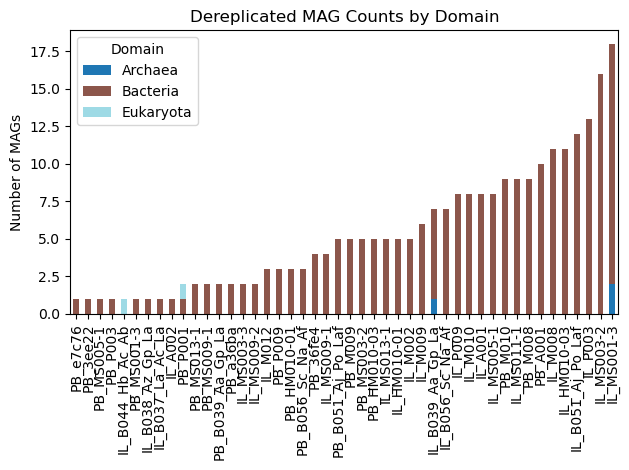

In [21]:
# Transpose (MAGs as rows, samples as columns)
table_df_T = table_df.T

# Merge with domain
merged = table_df_T.T.merge(tax_df, left_index=True, right_index=True)

merged = merged.rename(columns={"Taxon": "Domain"})

# Force numeric conversion for all sample columns
for col in merged.columns:
    if col != "Domain":
        merged[col] = pd.to_numeric(merged[col], errors='coerce')

# Group by domain, sum counts per sample
domain_counts = merged.groupby("Domain").sum().T

sample_totals = domain_counts.sum(axis=1)
domain_counts_sorted = domain_counts.loc[sample_totals.sort_values().index]

# Plot
plt.figure(figsize=(14,6))
domain_counts_sorted.plot(kind="bar", stacked=True, colormap="tab20")
plt.ylabel("Number of MAGs")
plt.title("Dereplicated MAG Counts by Domain")
plt.tight_layout()
plt.show()

[](#s)

#### Hierarchichal Clustering of Samples Based on MAG Presence/Absence

/opt/conda/envs/checkm/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/opt/conda/envs/checkm/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


<Figure size 1200x1200 with 0 Axes>

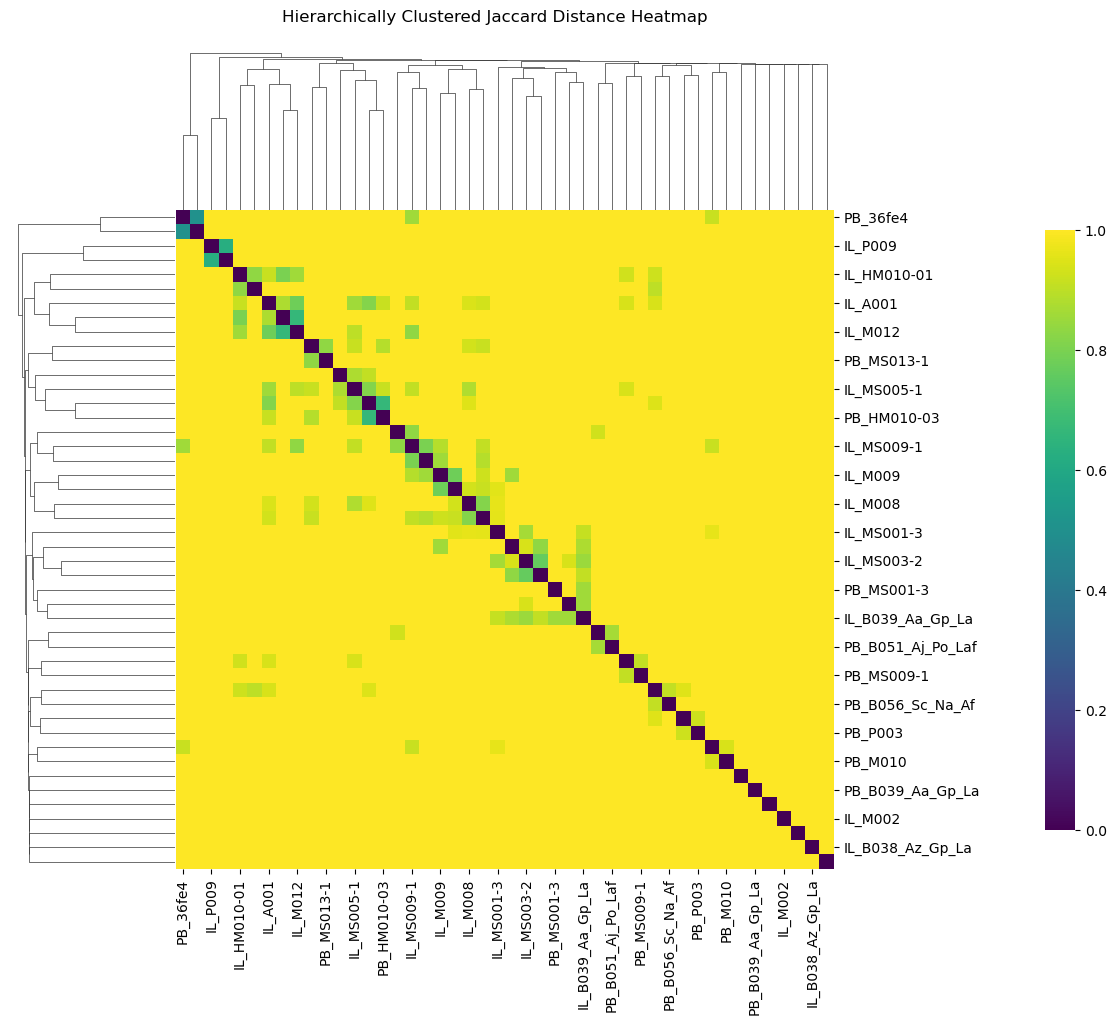

In [22]:
plt.figure(figsize=(12,12))

cg = sns.clustermap(
    jaccard_df,
    cmap="viridis",
    metric="euclidean",   # clustering metric (not Jaccard)
    method="average",     # UPGMA
    row_cluster=True,
    col_cluster=True,
    linewidths=0,
)

cg.cax.set_position([1.05, 0.2, 0.03, 0.6])

cg.fig.suptitle("Hierarchically Clustered Jaccard Distance Heatmap", y=1.02)
plt.show()

#### Pairwise Overlap of Dereplicated MAGs Among Samples

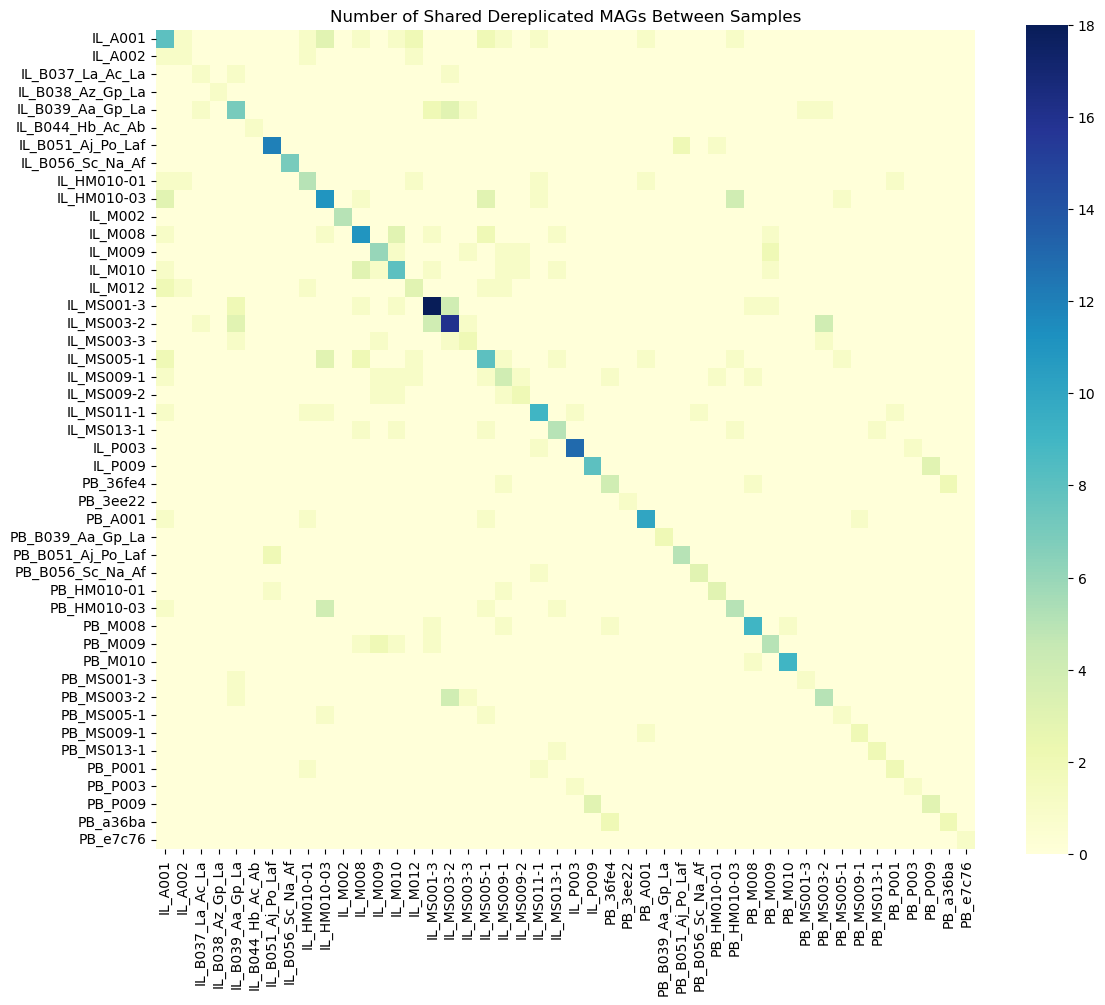

In [23]:
pa = (table_df > 0).astype(int)
shared = pa.T.dot(pa)

plt.figure(figsize=(12,10))
sns.heatmap(shared, cmap="YlGnBu", square=True)
plt.title("Number of Shared Dereplicated MAGs Between Samples")
plt.tight_layout()
plt.show()

#### Visualizing PCoA plots

In [24]:
pcoa_skbio = pcoa_art.view(skbio.OrdinationResults)

# Extract coordinates
pcoa_jac = pcoa_skbio.samples.copy()

In [25]:
# The axis names in the the PCoA file are not named `PC1`, 'PC2', etc. So we need to rename them.
num_axes = pcoa_jac.shape[1]

# Create names: PC1, PC2, PC3, ...
new_cols = [f"PC{i+1}" for i in range(num_axes)]

# Rename
pcoa_jac.columns = new_cols

In [26]:
var_exp = pcoa_skbio.proportion_explained

pc1_var = var_exp[0] * 100
pc2_var = var_exp[1] * 100

print(f"PC1 explains: {pc1_var:.2f}%")
print(f"PC2 explains: {pc2_var:.2f}%")

PC1 explains: 4.82%
PC2 explains: 4.22%


In [27]:
pcoa_merged = pcoa_jac.join(metadata, how="inner")

illumina = pcoa_merged[pcoa_merged["seq_tech"] == "Illumina"]
pacbio   = pcoa_merged[pcoa_merged["seq_tech"] == "PacBio"]

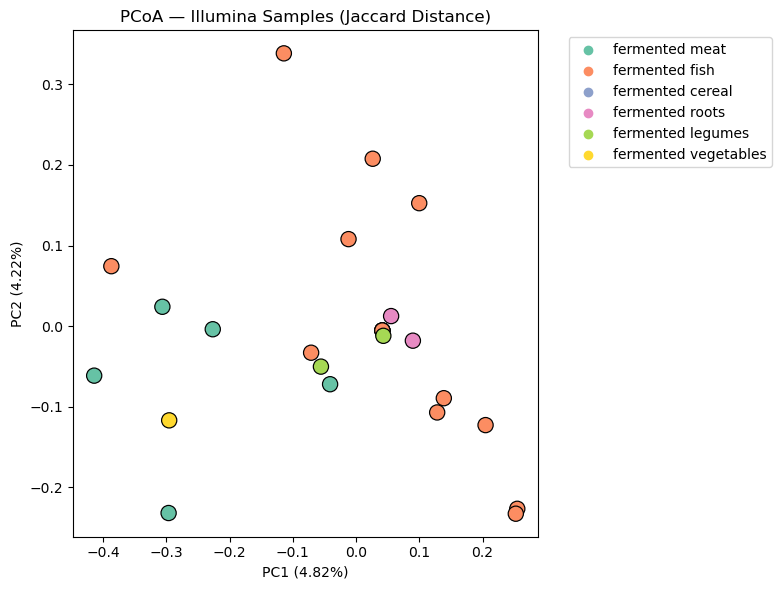

In [28]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=illumina,
    x="PC1", y="PC2",
    hue="category",
    s=120,
    palette="Set2",
    edgecolor="black"
)

plt.xlabel(f"PC1 ({pc1_var:.2f}%)")
plt.ylabel(f"PC2 ({pc2_var:.2f}%)")
plt.title("PCoA — Illumina Samples (Jaccard Distance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

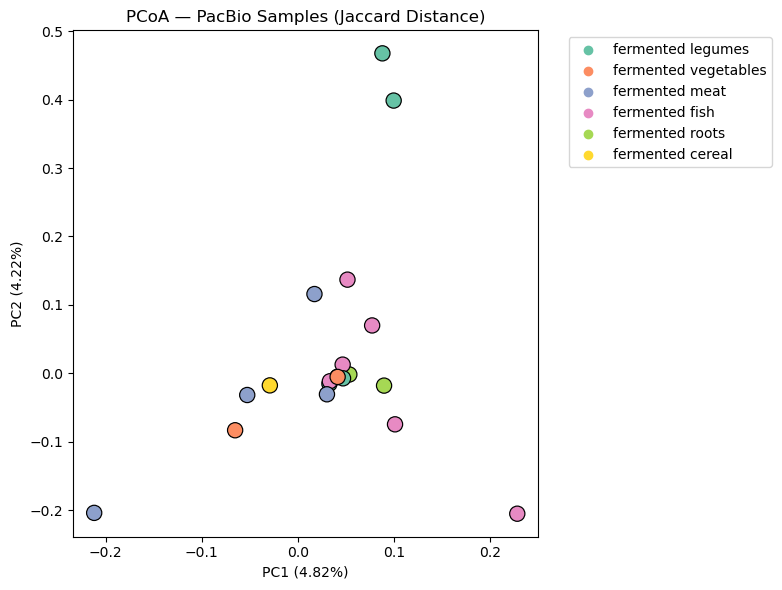

In [29]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pacbio,
    x="PC1", y="PC2",
    hue="category",
    s=120,
    palette="Set2",
    edgecolor="black"
)

plt.xlabel(f"PC1 ({pc1_var:.2f}%)")
plt.ylabel(f"PC2 ({pc2_var:.2f}%)")
plt.title("PCoA — PacBio Samples (Jaccard Distance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

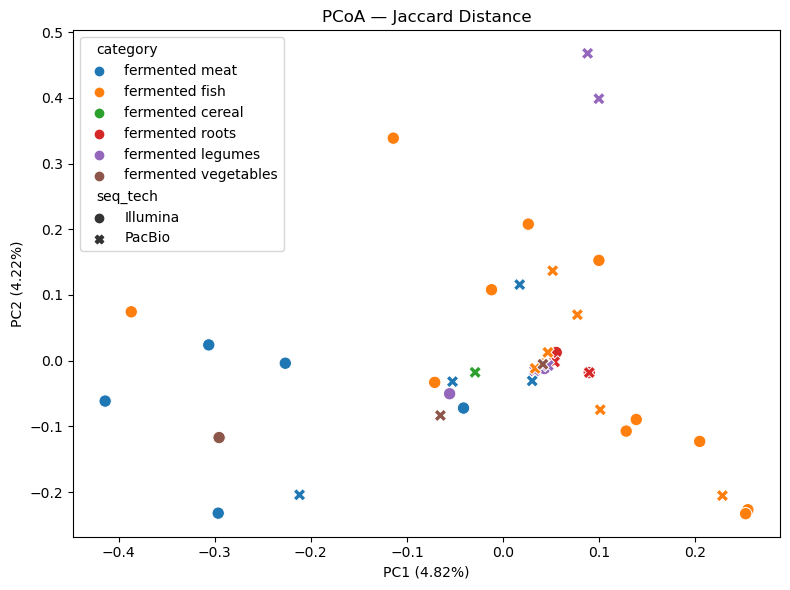

In [30]:
df = pcoa_jac.join(metadata)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="PC1", y="PC2",
    hue="category",
    style="seq_tech",
    s=80,
    palette="tab10"
)

plt.xlabel(f"PC1 ({pc1_var:.2f}%)")
plt.ylabel(f"PC2 ({pc2_var:.2f}%)")
plt.title("PCoA — Jaccard Distance")
plt.tight_layout()
plt.show()

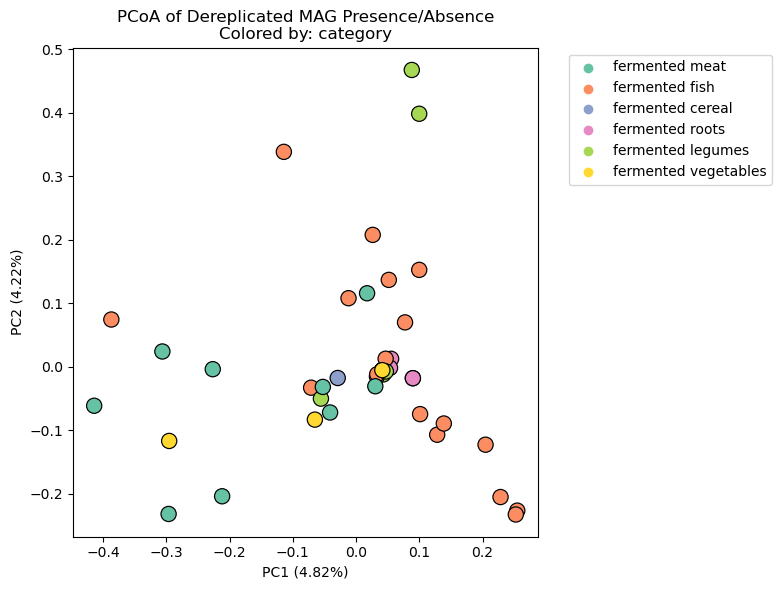

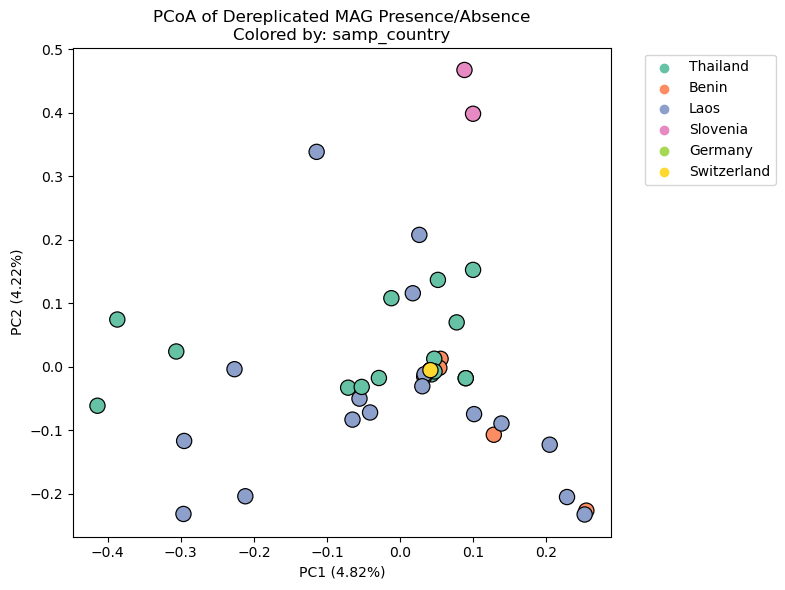

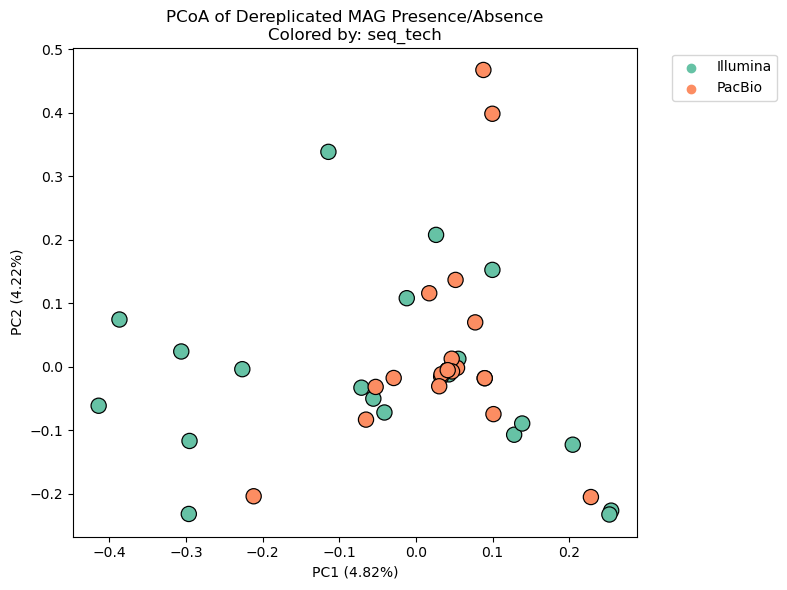

In [31]:
# PCoA plot function
def pcoa_plot(df, color_col):
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=df, x="PC1", y="PC2",
        hue=color_col,
        s=120, edgecolor="black", palette="Set2"
    )
    plt.xlabel(f"PC1 ({pc1_var:.2f}%)")
    plt.ylabel(f"PC2 ({pc2_var:.2f}%)")
    plt.title(f"PCoA of Dereplicated MAG Presence/Absence\nColored by: {color_col}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# plotting the PCoA for different metadata information 
pcoa_plot(df, "category")
pcoa_plot(df, "samp_country")
pcoa_plot(df, "seq_tech")

#### PERMANOVA results for food category

In [32]:
Visualization.load(f"{data_dir}/derep_permanova_category_taxonomy.qzv")

<visualization: Visualization uuid: e4237458-613f-4fe0-9389-80ca7de05546>

#### Distance of Samples to Food Category Centroids

/opt/conda/envs/checkm/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/checkm/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/checkm/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


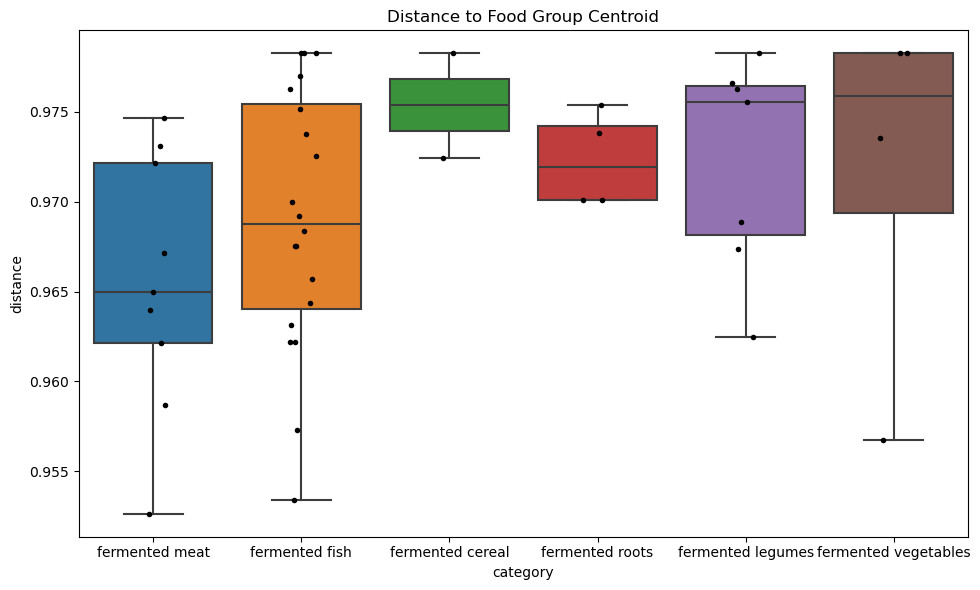

In [33]:
def distance_to_centroid(dm, metadata, group_col):
    dm = dm.loc[metadata.index, metadata.index]
    results = []

    for group in metadata[group_col].unique():
        samples = metadata.index[metadata[group_col] == group]
        sub_dm = dm.loc[samples, samples]

        centroid = sub_dm.mean().mean()

        for s in samples:
            results.append([group, s, dm.loc[s].mean()])

    return pd.DataFrame(results, columns=[group_col, "sample", "distance"])

dist_df = distance_to_centroid(jaccard_df, metadata, "category")

plt.figure(figsize=(10,6))
sns.boxplot(data=dist_df, x="category", y="distance")
sns.stripplot(data=dist_df, x="category", y="distance", color="black", size=4)
plt.title("Distance to Food Group Centroid")
plt.tight_layout()
plt.show()

#### PERMANOVA results for sampling country

In [34]:
Visualization.load(f"{data_dir}/derep_permanova_country_taxonomy.qzv")

<visualization: Visualization uuid: 47fc3cd9-85d6-4909-8323-98cd55c90e77>

/opt/conda/envs/checkm/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/checkm/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/checkm/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


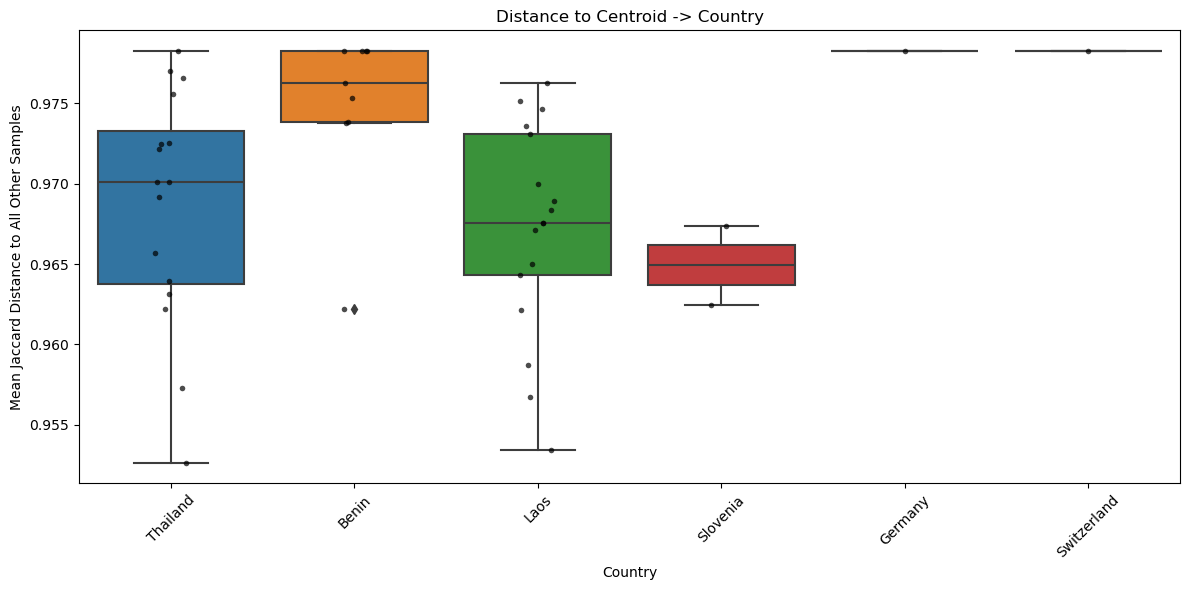

In [35]:
dist_country = distance_to_centroid(jaccard_df, metadata, "samp_country")

plt.figure(figsize=(12,6))
sns.boxplot(data=dist_country, x="samp_country", y="distance")
sns.stripplot(data=dist_country, x="samp_country", y="distance", 
              color="black", size=4, alpha=0.7)

plt.title("Distance to Centroid -> Country")
plt.ylabel("Mean Jaccard Distance to All Other Samples")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div style="border:2px solid red; padding:10px; color:red; font-weight:bold;">
Note: This is not the end of the analysis. There are more relevant visualizations I want to generate, and some of the ones included in this notebook will either be changed or removed completely. Additionally, we are also planning on doing an analysis incorporating phylogeny. To incorporate phylogenetic relationships into the beta diversity analysis, a phylogenomic tree of the dereplicated MAGs would first need to be generated. Once available, this would allow the use of phylogenetic metrics such as unweighted UniFrac.
</div>